# "[Recommender System] Neural Collaborative Filtering Paper Implementation"
> 2017, Neural Collaborative Filtering Paper Implementation

- toc: true
- badges: true
- comments: true
- categories: [AI]
- tags: [paper, recommender system, neural, collaborative filtering, Implementation]

# Neural Collaborative Filtering Paper Implementation

## Configuration

In [4]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import math
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

## Load Dataset

- KMRD 데이터셋 활용

In [5]:
def read_data(data_dir, data_filename):
    df = pd.read_csv(os.path.join(data_dir, data_filename))
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=7, shuffle=True)
    return train_df, val_df

In [6]:
data_dir = '../datasets/kmrd/kmr_dataset/datafile/kmrd-small'
data_filename = 'rates.csv'

In [7]:
train_df, val_df = read_data(data_dir, data_filename)

In [8]:
train_df.shape

(112568, 4)

In [9]:
train_df.head()

,user,movie,rate,time
49270,5022,10048,10,1263194040
21206,1391,10018,9,1311682500
103762,23267,10071,10,1274965260
60013,6952,10200,9,1245919800
98439,20620,10111,9,1369739760


In [10]:
val_df.shape

(28142, 4)

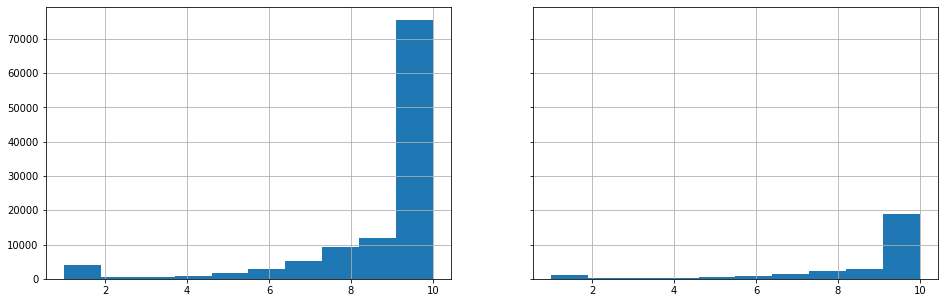

In [11]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(16, 5))
ax = ax.ravel()

train_df['rate'].hist(ax=ax[0])
val_df['rate'].hist(ax=ax[1])
plt.show()

In [12]:
train_df['rate'].describe()

count    112568.000000
mean          8.954703
std           2.104698
min           1.000000
25%           9.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rate, dtype: float64

In [13]:
movies_df = pd.read_csv(os.path.join(data_dir, 'movies.txt'), sep='\t', encoding='utf-8')
movies_df = movies_df.set_index('movie')
movies_df.head()

,title,title_eng,year,grade
movie,,,,
10001,시네마 천국,"Cinema Paradiso , 1988",2013.0,전체 관람가
10002,빽 투 더 퓨쳐,"Back To The Future , 1985",2015.0,12세 관람가
10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가
10004,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가
10005,스타워즈 에피소드 4 - 새로운 희망,"Star Wars , 1977",1997.0,PG


In [14]:
castings_df = pd.read_csv(os.path.join(data_dir, 'castings.csv'), encoding='utf-8')
castings_df.head()

,movie,people,order,leading
0,10001,4374,1,1
1,10001,178,2,1
2,10001,3241,3,1
3,10001,47952,4,1
4,10001,47953,5,0


In [15]:
countries_df = pd.read_csv(os.path.join(data_dir, 'countries.csv'), encoding='utf-8')
countries_df.head()

,movie,country
0,10001,이탈리아
1,10001,프랑스
2,10002,미국
3,10003,미국
4,10004,미국


In [16]:
genres_df = pd.read_csv(os.path.join(data_dir, 'genres.csv'), encoding='utf-8')
genres_df.head()

,movie,genre
0,10001,드라마
1,10001,멜로/로맨스
2,10002,SF
3,10002,코미디
4,10003,SF


In [17]:
combined_genres_df = pd.DataFrame(genres_df.groupby('movie').apply(lambda x: '/'.join(x['genre'])), columns=['genres'])
combined_genres_df.head()

,genres
movie,
10001,드라마/멜로/로맨스
10002,SF/코미디
10003,SF/코미디
10004,서부/SF/판타지/코미디
10005,판타지/모험/SF/액션


In [18]:
combined_castings_df = pd.DataFrame(castings_df.groupby('movie').apply(lambda x: list(x['people'])), columns=['people'])
combined_castings_df.head()

,people
movie,
10001,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ..."
10002,"[1076, 4603, 917, 8637, 5104, 9986, 7470, 9987]"
10003,"[1076, 4603, 917, 5104, 391, 5106, 5105, 5107,..."
10004,"[1076, 4603, 1031, 5104, 10001, 5984, 10002, 1..."
10005,"[1007, 535, 215, 1236, 35]"


In [19]:
combined_countries_df = pd.DataFrame(countries_df.groupby('movie').apply(lambda x: ','.join(x['country'])), columns=['countries'])
combined_countries_df.head()

,countries
movie,
10001,"이탈리아,프랑스"
10002,미국
10003,미국
10004,미국
10005,미국


In [20]:
movies_df = pd.concat([movies_df, combined_genres_df, combined_castings_df, combined_countries_df], axis=1)
movies_df.head()

,title,title_eng,year,grade,genres,people,countries
movie,,,,,,,
10001,시네마 천국,"Cinema Paradiso , 1988",2013.0,전체 관람가,드라마/멜로/로맨스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","이탈리아,프랑스"
10002,빽 투 더 퓨쳐,"Back To The Future , 1985",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 8637, 5104, 9986, 7470, 9987]",미국
10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 5104, 391, 5106, 5105, 5107,...",미국
10004,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가,서부/SF/판타지/코미디,"[1076, 4603, 1031, 5104, 10001, 5984, 10002, 1...",미국
10005,스타워즈 에피소드 4 - 새로운 희망,"Star Wars , 1977",1997.0,PG,판타지/모험/SF/액션,"[1007, 535, 215, 1236, 35]",미국


## Dataset Loader

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

class DatasetLoader:
    
    def __init__(self, data_path):
        self.train_df, val_temp_df = train_test_split(pd.read_csv(data_path),
                                                      test_size=0.2, random_state=7, shuffle=True)
        self.min_rating = self.train_df.rate.min()
        self.max_rating = self.train_df.rate.max()
        self.unique_users = self.train_df.user.unique()
        self.num_users = len(self.unique_users)
        self.user_to_index = {original: idx for idx, original in enumerate(self.unique_users)}
        self.unique_movies = self.train_df.movie.unique()
        self.num_movies = len(self.unique_movies)
        self.movie_to_index = {original: idx for idx, original in enumerate(self.unique_movies)}
        self.val_df = val_temp_df[val_temp_df.user.isin(self.unique_users) \
                                  & val_temp_df.movie.isin(self.unique_movies)]
        
    def generate_trainset(self):
        X_train = pd.DataFrame({'user': self.train_df.user.map(self.user_to_index),
                                'movie': self.train_df.movie.map(self.movie_to_index)})
        y_train = self.train_df['rate'].astype(np.float32)

        return X_train, y_train

    def generate_valset(self):
        X_val = pd.DataFrame({'user': self.val_df.user.map(self.user_to_index),
                              'movie': self.val_df.movie.map(self.movie_to_index)})
        y_val = self.val_df['rate'].astype(np.float32)
        return X_val, y_val

## Model Structure

In [22]:
from torch import nn, optim

class FeedForwardEmbedNN(nn.Module):
    
    def __init__(self, n_users, n_movies, hidden, dropouts, n_factors, embedding_dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.movie_emb = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden_layers = nn.Sequential(*list(self.generate_layers(n_factors*2, hidden, dropouts)))
        self.fc = nn.Linear(hidden[-1], 1)
                                           
    def generate_layers(self, n_factors, hidden, dropouts):
        assert len(dropouts) == len(hidden)
        idx = 0
        while idx < len(hidden):
            if idx == 0:
                yield nn.Linear(n_factors, hidden[idx])
            else:
                yield nn.Linear(hidden[idx-1], hidden[idx])
            yield nn.ReLU()
            yield nn.Dropout(dropouts[idx])
            idx += 1
                                         
    def forward(self, users, movies, min_rating=0.5, max_rating=5):
        concat_features = torch.cat([self.user_emb(users), self.movie_emb(movies)], dim=1)
        x = F.relu(self.hidden_layers(concat_features))
        out = torch.sigmoid(self.fc(x))
        out = (out * (max_rating - min_rating)) + min_rating
        return out
    
    def predict(self, users, movies):
        output_scores = self.forward(users, movies)
        return output_scores

In [23]:
class BatchIterator:

    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)

        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k * bs:(k + 1) * bs], self.y[k * bs:(k + 1) * bs]

In [24]:
def batches(X, y, bs=32, shuffle=True):
    for x_batch, y_batch in BatchIterator(X, y, bs, shuffle):
        x_batch = torch.LongTensor(x_batch)
        y_batch = torch.FloatTensor(y_batch)
        yield x_batch, y_batch.view(-1, 1)

## Train model

In [25]:
def model_train(ds, config):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    X_train, y_train = ds.generate_trainset()
    X_valid, y_valid = ds.generate_valset()
    print(f'TrainSet Info: {ds.num_users} users, {ds.num_movies} movies')

    model = FeedForwardEmbedNN(
        n_users=ds.num_users, n_movies=ds.num_movies,
        n_factors=config['num_factors'], hidden=config['hidden_layers'],
        embedding_dropout=config['embedding_dropout'], dropouts=config['dropouts']
    )
    model.to(device)

    batch_size = config['batch_size']
    num_epochs = config['num_epochs']
    max_patience = config['total_patience']
    num_patience = 0
    best_loss = np.inf

    criterion = nn.MSELoss(reduction='sum')
    criterion.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'],
                           weight_decay=config['weight_decay'])

    result = dict()
    for epoch in tqdm(range(num_epochs)):
        training_loss = 0.0
        for batch in batches(X_train, y_train, shuffle=True, bs=batch_size):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # with torch.no_grad() 와 동일한 syntax 입니다
            with torch.set_grad_enabled(True):
                outputs = model(x_batch[:, 0], x_batch[:, 1], ds.min_rating, ds.max_rating)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            training_loss += loss.item()
        result['train'] = training_loss / len(X_train)

        # Apply Early Stopping criteria and save best model params
        val_outputs = model(torch.LongTensor(X_valid.user.values).to(device),
                            torch.LongTensor(X_valid.movie.values).to(device), ds.min_rating, ds.max_rating)
        val_loss = criterion(val_outputs.to(device), torch.FloatTensor(y_valid.values).view(-1, 1).to(device))
        result['val'] = float((val_loss / len(X_valid)).data)

        if val_loss < best_loss:
            print('Save new model on epoch: %d' % (epoch + 1))
            best_loss = val_loss
            result['best_loss'] = val_loss
            torch.save(model.state_dict(), config['save_path'])
            num_patience = 0
        else:
            num_patience += 1

        print(f'[epoch: {epoch+1}] train: {result["train"]} - val: {result["val"]}')

        if num_patience >= max_patience:
            print(f"Early Stopped after epoch {epoch+1}")
            break

    return result

In [26]:
data_dir = '../datasets/kmrd/kmr_dataset/datafile/kmrd-small'
data_filename = 'rates.csv'
data_path = os.path.join(data_dir, data_filename)
dataset = DatasetLoader(data_path)

In [27]:
config = {
    "num_factors": 16,
    "hidden_layers": [64, 32, 16],
    "embedding_dropout": 0.05,
    "dropouts": [0.3, 0.3, 0.3],
    "learning_rate": 1e-3,
    "weight_decay": 1e-5,
    "batch_size": 8,
    "num_epochs": 3,
    "total_patience": 30,
    "save_path": "params.data"
}

In [28]:
model_train(dataset, config)

TrainSet Info: 44554 users, 594 movies


 33%|███▎      | 1/3 [00:22<00:44, 22.32s/it]

Save new model on epoch: 1
[epoch: 1] train: 4.282606438265097 - val: 4.0021843910217285


 67%|██████▋   | 2/3 [00:43<00:21, 21.93s/it]

Save new model on epoch: 2
[epoch: 2] train: 3.695007214637341 - val: 3.7426116466522217


100%|██████████| 3/3 [01:06<00:00, 22.07s/it]

Save new model on epoch: 3
[epoch: 3] train: 3.2749883148887515 - val: 3.700655937194824


{'train': 3.2749883148887515,
 'val': 3.700655937194824,
 'best_loss': tensor(75152.9219, device='cuda:0', grad_fn=<MseLossBackward0>)}

## Test

In [29]:
def model_valid(user_id_list, movie_id_list, data_path):
    dataset = DatasetLoader(data_path)
    processed_test_input_df = pd.DataFrame({
        'user_id': [dataset.user_to_index[x] for x in user_id_list],
        'movie_id': [dataset.movie_to_index[x] for x in movie_id_list]
    })

    # 학습한 모델 load하기 
    my_model = FeedForwardEmbedNN(dataset.num_users, dataset.num_movies,
                       config['hidden_layers'], config['dropouts'], config['num_factors'], config['embedding_dropout'])
    my_model.load_state_dict(torch.load('params.data'))
    prediction_outputs = my_model.predict(users=torch.LongTensor(processed_test_input_df.user_id.values),
                     movies=torch.LongTensor(processed_test_input_df.movie_id.values))

    return prediction_outputs

In [30]:
movie_id_list = [10253, 10102, 10007]
user_id = 11242
user_id_list = [user_id] * len(movie_id_list)
pred_results = [float(x) for x in model_valid(user_id_list, movie_id_list, data_path)]

result_df = pd.DataFrame({
    'userId': user_id_list,
    'movieId': movie_id_list,
    # 'movieName': [movieName_dict[x] for x in movie_id_list],
    # 'genres': [genres_dict[x] for x in movie_id_list],
    'pred_ratings': pred_results
})

result_df.sort_values(by='pred_ratings', ascending=False)

,userId,movieId,pred_ratings
1,11242,10102,4.948718
2,11242,10007,4.815145
0,11242,10253,4.800036
